open X:/Phagocytosis/sRBC/20190614cs1/track_4/test/Cell_CamB_ch0_stack0040_488nm_0301192msec_0003988839msecAbs_decon.tif;
open X:/Phagocytosis/sRBC/20190614cs1/track_4/test/Cell_CamA_ch1_stack0040_560nm_0301192msec_0003988839msecAbs_decon.tif;

material dull;

lighting full depthCue false;

windowsize 800 800;

volume #2 color #ffd059 level 158.7 step 2 region 46,55,0,143,130,228;

volume #1 color #2b5884 level 90 step 2;

surface dust #1,2 metric "volume rank" size 1;

volume #1,2 voxelSize 0.1028;

view matrix camera -0.98748,0.041568,-0.15219,5.4123,-0.14414,-0.62984,0.76323,43.551,-0.06413,0.77561,0.62794,32.539;
view name test;

measure convexity #1 palette purples range 0.3,.3 smoothingIterations 10;

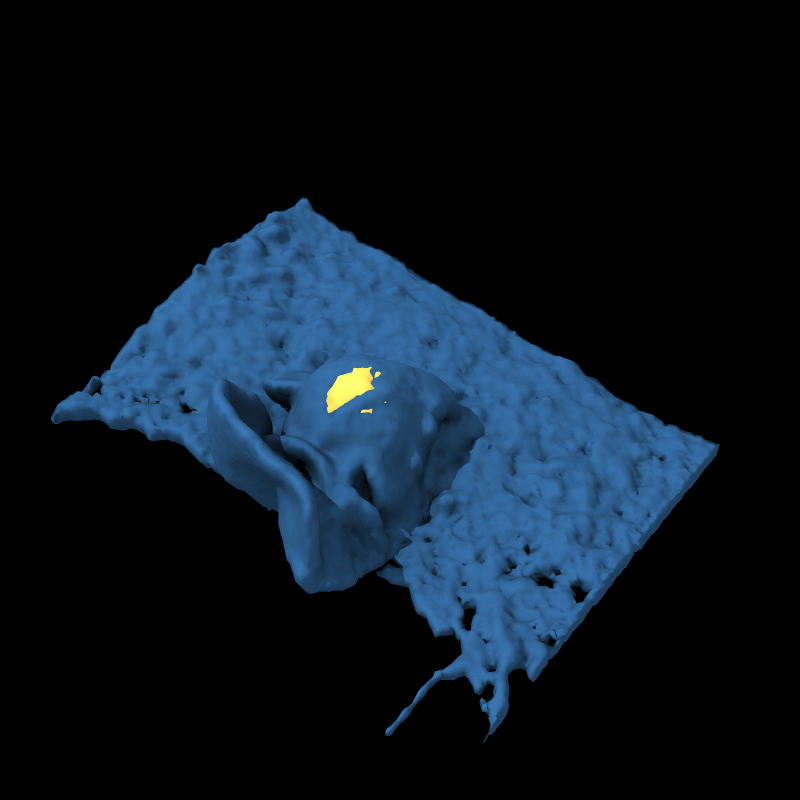 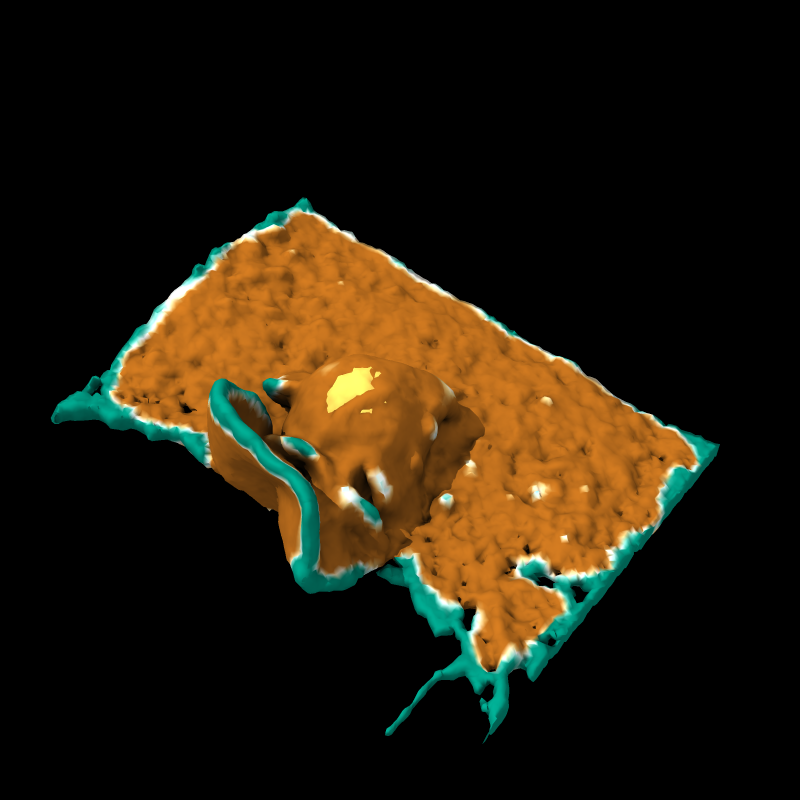

In [ ]:
from chimerax.color_key import show_key
from chimerax.core import colors
from chimerax.std_commands.wait import wait
from chimerax.core.commands import (BoolArg, Bounded, CmdDesc, ColormapArg,
                                    ColormapRangeArg, Int2Arg, IntArg,
                                    SurfacesArg, StringArg)
from chimerax.core.commands.cli import EnumOf
from chimerax.map.volumecommand import volume
from chimerax.std_commands.cd import (cd)
from os.path import exists
from numpy import (arccos, array, full, inf, isnan, mean, nan, nanmax, nanmean,
                   nanmin, pi, ravel_multi_index, sign, split, sqrt, subtract,
                   count_nonzero, swapaxes, savetxt, column_stack,nansum, nanstd,
                   unique, column_stack, round_, int64, abs, digitize, linspace,
                   zeros, where, delete)
from scipy.ndimage import (binary_dilation, binary_erosion,
                           generate_binary_structure, iterate_structure, gaussian_filter)
from scipy.spatial import KDTree
import numpy
import scipy
import matplotlib.pyplot as plt
import skimage

In [ ]:
metric='RPD'
target ='sRBC'
size=(.1028,.1028,.1028)
palette=None
color_range= None
key=False
volume(session, voxel_size= size)
s= session
m= s.models
radius = 9
target_r = 2
centroid = mean(m[3].vertices, axis = 0)

x_coord, y_coord, z_coord = split(subtract(m[1].vertices, centroid), 3, 1)

z_squared = z_coord ** 2
y_squared = y_coord ** 2
x_squared = x_coord ** 2

distance = sqrt(z_squared + y_squared + x_squared)

distxy = sqrt(x_squared + y_squared)

""
theta = sign(y_coord)*arccos(x_coord / distxy)

phi = arccos(z_coord / distance) * (180/numpy.pi)

"""Logic to identify vertices in the targets local (defined by radius input) around target's upper hemisphere"""
abovePhi = phi >= (pi/2)

radialClose = (distance  < radius) & (distance > target_r)

con = m[1].convexity
edgeind = (con>.3)
palette = None
color_range = 'full'
measurement = edgeind+0
palette_string = 'purples'
max_range = 15

if isnan(measurement).all():
    measurement[:] = 0


In [ ]:
if palette is None:
    palette = colors.BuiltinColormaps[palette_string]

if color_range is not None and color_range != 'full':
    rmin, rmax = color_range
elif color_range == 'full':
    rmin, rmax = nanmin(measurement), nanmax(measurement)
else:
    rmin, rmax = (0, max_range)

In [ ]:
cmap = palette.rescale_range(rmin, rmax)
m[1].vertex_colors = cmap.interpolated_rgba8(measurement[:,0])

Using the native chimeraX function we can identify high curvature edges of lamella in FLMs

![MicrosoftTeams-image (1).png](<attachment:MicrosoftTeams-image (1).png>)

Image is paletted such that the purple regions are regions in the upper hemisphere search of 8 um.

Result: This shows promise as a parameter we can use to isolate large edges. Smaller edges of the lamella are not being identified well but specific segmenta are seen decently well. To take this a step further we want to track these lamella edges in time. proposed attempt will be to use a query tree approach to find where the membrane is growing to.

Made a measure command to find high curvature regions of FLM membrane frames t and t+1 within an 8 um sphere search around the target (sRBC). Then using the query function (author: BLS) (Euclidean) distances of these high curvature regions are paletted.

 

Attempted to implement the methodology above into the main command list as an iterative object to be run by several workers. This failed and the chimera session claimed that the " 'list' object does not have attribute surface .vertices ". I am currently using the work around of designing the script to be run on a single frame at a time then calling it as a perframe command in chimeraX’s command line.

 

Result: In the timeseries implementation of this script I have found that there is a large variability in the curved regions found. Some of these regions will spontaneously disappear giving very high regions of movement. Additionally, some in some frames of movement I find that there are apparent wrinkles that get palleted but may not be equivalent to lamella edges. Where it stands, I think this method needs work but we should work on refining the edge detection further and work towards defining temporal edge motions. Moving forward I will want to refine the threshold used in identifying membrane edges and improving calling of this function.

<video src="EdgeMotion.mp4" controls title="Title"></video>

Found that edges were identified well in the intial implementation. This let me to question my method of determining motion with the query search approach. In the calculation I previously importeddata with "NaN" values to ignore all vertices that were not found in the convexity measurement. 

Likely there is a small issue with importing NaNs in the querry seach. where it stands I have removed this and the script is now functional. for the large lamela case.

sRBC - rough cup

<video src="edgemotionFixed.mp4" controls title="Title"></video>

mRBC with Maip - rough cup

<video src="mRBCmiap-edges.mp4" controls title="Title"></video>

mRBC - smooth cup

<video src="mRBC-edges.mp4" controls title="Title"></video>



Goal:
Use identified edges to define total path length of lamella edges. from reconstructed image

In [ ]:
con = m[1].convexity
edgeind = (con>.3)

Points= (edgeind+0)

"""Logic statments for solving the unique X,Y coordinates in the upper hemisphere search"""
XYZ_SearchR = (distance  < radius) 
'& (z_coord > min(z_coord[numpy.where(phi>175)])+.5)'
XYZ_deletes = where(XYZ_SearchR==0)

"""Solving for unique X,Y,Z coordinates in the search"""
xx=x_coord[:,0]*Points
yy=y_coord[:,0]*Points
zz=z_coord[:,0]*Points

xyz_raw = column_stack((xx,yy,zz))

xyz=unique(delete(xyz_raw,XYZ_deletes,axis=0),axis=0)

"""Defining the pixel size from human defined parameter"""
width = size[0]

"""Defining steps that will are approximately one pixel in length"""
steps = int64(round_(abs((2*radius)/(width))))

"""Indexing the vertices that fall in one pixel of eachother along each axis""" 
"""Weird nearest neighbors approach"""    
xbins = digitize(xyz[:,0],linspace(-9,9,steps))
ybins = digitize(xyz[:,1],linspace(-9,9,steps))
zbins = digitize(xyz[:,2],linspace(-9,9,steps))

"""Making an artificial binary mask of binned vertices into 'pixels' from vertice location"""

ArtImgxyz= zeros([steps,steps,steps])
ArtImgxyz[xbins,ybins,zbins]= 1

"""Filling holes and cutts in image"""
ArtImg_Filledxyz = binary_erosion(((gaussian_filter(ArtImgxyz,.2))>0),border_value=1,iterations=1)

pos=where(ArtImg_Filledxyz==1)

fig= plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(pos[0], pos[1], pos[2], c='black')
ax.set_title('Reconstructed image 0')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Chimera Session

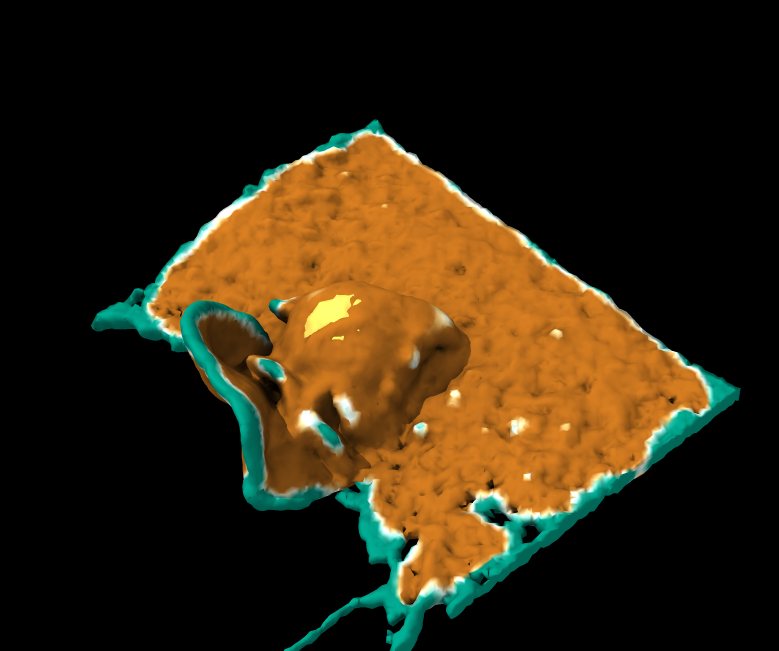

In [ ]:
skel=skimage.morphology.skeletonize((ArtImg_Filledxyz*1),method='lee')
pos=where(skel==1)

fig= plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(pos[0], pos[1], pos[2], c='black')
ax.set_title('Skeletonized reconstructed image 0')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Reconstructed Image

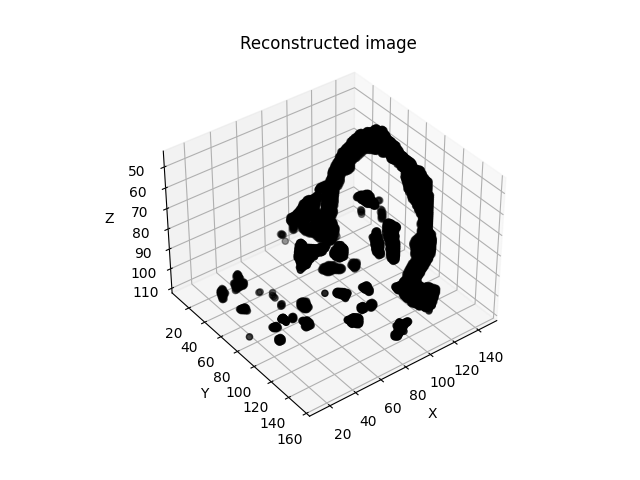

Skeletonized Image

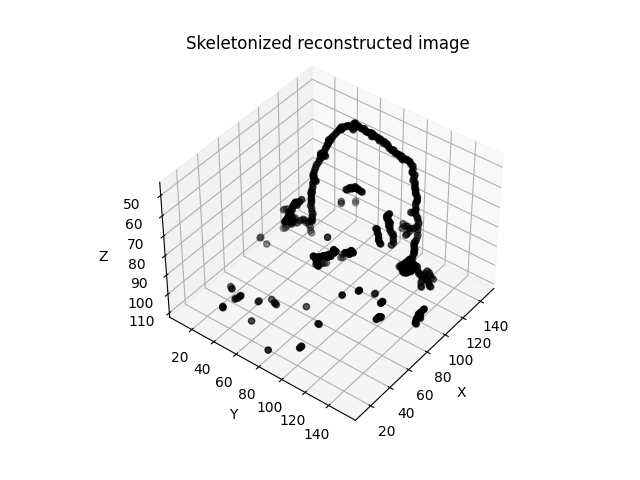

In [ ]:
con = m[1].convexity
edgeind = (con>.3)

Points= (edgeind+0)

"""Logic statments for solving the unique X,Y coordinates in the upper hemisphere search"""
XYZ_SearchR = (distance  < radius) & (z_coord > (min( z_coord[ where(phi<165) ])+0.5))
XYZ_deletes = where(XYZ_SearchR==0)

"""Solving for unique X,Y,Z coordinates in the search"""
xx=x_coord[:,0]*Points
yy=y_coord[:,0]*Points
zz=z_coord[:,0]*Points

xyz_raw = column_stack((xx,yy,zz))

xyz=unique(delete(xyz_raw,XYZ_deletes,axis=0),axis=0)

"""Defining the pixel size from human defined parameter"""
width = size[0]

"""Defining steps that will are approximately one pixel in length"""
steps = int64(round_(abs((2*radius)/(width))))

"""Indexing the vertices that fall in one pixel of eachother along each axis""" 
"""Weird nearest neighbors approach"""    
xbins = digitize(xyz[:,0],linspace(-9,9,steps))
ybins = digitize(xyz[:,1],linspace(-9,9,steps))
zbins = digitize(xyz[:,2],linspace(-9,9,steps))

"""Making an artificial binary mask of binned vertices into 'pixels' from vertice location"""

ArtImgxyz= zeros([steps,steps,steps])
ArtImgxyz[xbins,ybins,zbins]= 1

"""Filling holes and cutts in image"""
ArtImg_Filledxyz = binary_erosion(((gaussian_filter(ArtImgxyz,.2))>0),border_value=1,iterations=1)

pos=where(ArtImg_Filledxyz==1)

fig= plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(pos[0], pos[1], pos[2], c='black')
ax.set_title('Reconstructed image 0')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

This addition of a z_coord limit states that vertices at within half a micron from the lowest point under the target are outside the search. It works similar to a clipping function. 

The axis are reversed given that ChimeraX assumes our images are organized by their them and not ours.

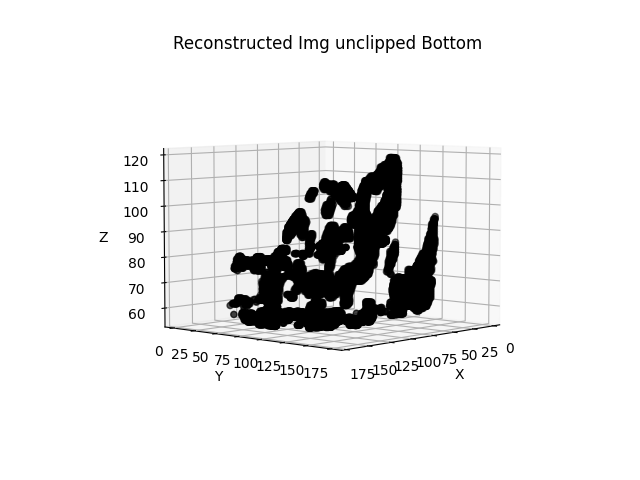 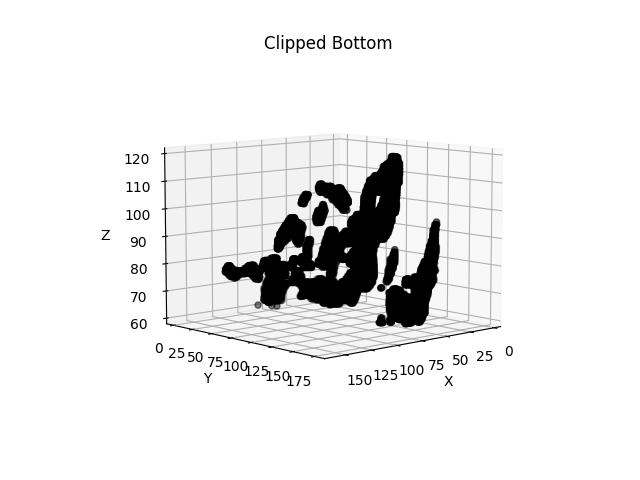

error displayed when attempting to clip from the min vertice heigh in a phi search, if no vertices are displayed.

"ValueError: zero-size array to reduction operation minimum which has no identity"

![error for no mem in clipping range when using min.png](<attachment:error for no mem in clipping range when using min.png>)
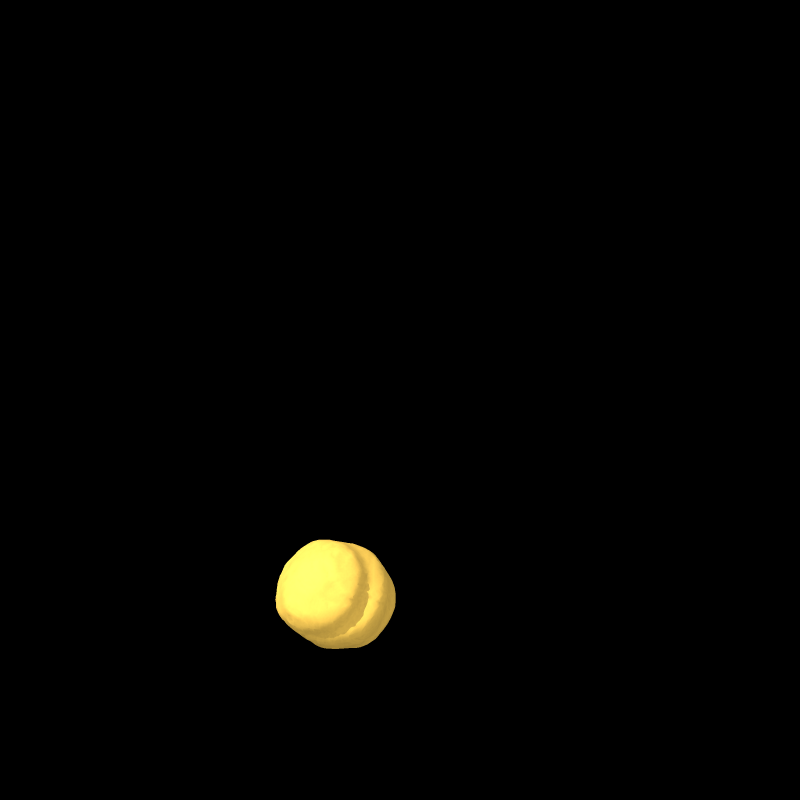

Using the skeletonized image to excluse ridges that fall under a threshold

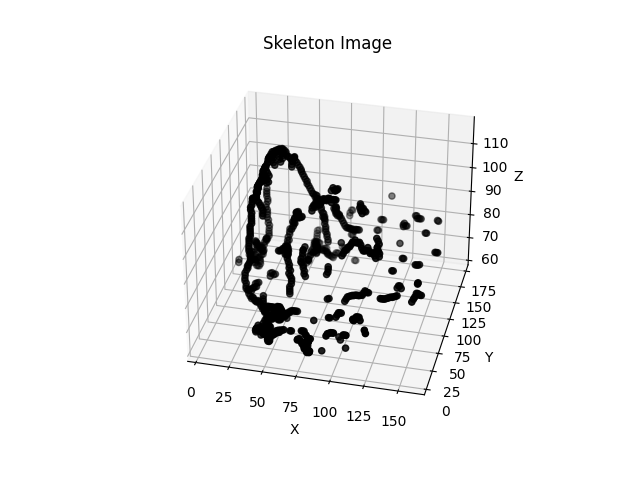

In [ ]:
unique,counts=numpy.unique(cc,return_counts=True)

unique
Out[26]: 
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55], dtype=int64)

counts
Out[27]: 
array([5358483,       2,      74,     399,       5,       9,      28,
             3,      22,      73,      13,       2,      21,       4,
            32,      28,       4,       8,       1,       4,       2,
             2,       2,       1,       1,       2,       6,      36,
             5,       1,       1,      18,       6,       3,       1,
             2,       3,       3,       8,       1,       2,      12,
             5,       1,       2,       2,       2,       4,       4,
             4,       2,       3,       3,       5,       2,       3],
      dtype=int64)

f[f==numpy.max(counts)]=0

f
Out[59]: 
array([  0,   2,  74, 399,   5,   9,  28,   3,  22,  73,  13,   2,  21,
         4,  32,  28,   4,   8,   1,   4,   2,   2,   2,   1,   1,   2,
         6,  36,   5,   1,   1,  18,   6,   3,   1,   2,   3,   3,   8,
         1,   2,  12,   5,   1,   2,   2,   2,   4,   4,   4,   2,   3,
         3,   5,   2,   3], dtype=int64)

p=where(f >= 10)

p
Out[62]: (array([ 2,  3,  6,  8,  9, 10, 12, 14, 15, 27, 31, 41], dtype=int64),)


pos=where(numpy.isin(cc,p)==True)

fig= plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(pos[0], pos[1], pos[2], c='black')
ax.set_title('Reconstructed image 0')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

Exclusion of ridges smaller than 1 um

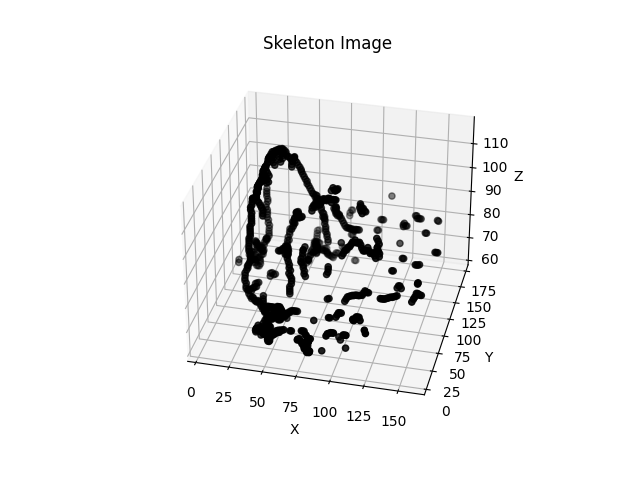

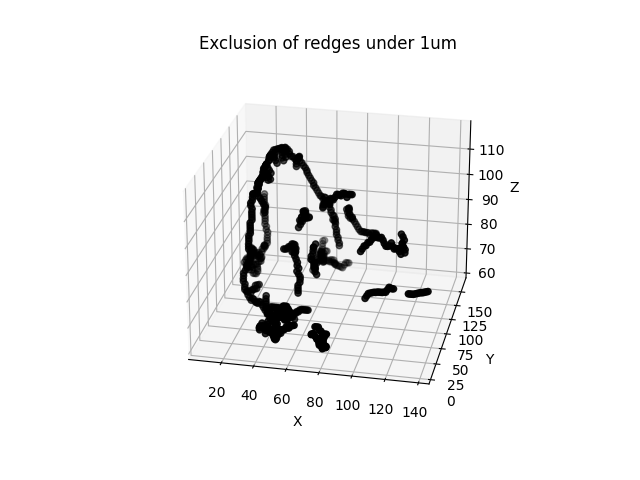

Computationally, I've proven that we can do a size exclusion on identified redges using curvature. This will now nee to be applied to the 3d render as a readily avalible display.
